### Bayesian logistic Regression for a9a Dataset C-ULA

This notebook deals with the Centralized Unadjasted Langevin Dynamics Algorithm(C-ULA). We are going to apply C-ULA for bayesian logistic regression. Thanks to such logistic regression one would like to solve problem of binary classification.

Since we consider C-ULA , then we have to say, that we have the only agent that has own personal data. Thus, we have one datset $\mathcal{D}$ = $\{x_{i} , y_{i}\}_{i=1}^{n}$, where $x_{i} \in \mathbb{R}^{d \times 1}$ ,whereas $y_{i} \in \mathbb{R}$. For bayesian logistic regression one can create one linear model, which is composed in_features = d and out_features = 1(class). Then, we have d parameters of this linear model, let me denote as $w \in \mathbb{R}^{1 \times d}$.

We are used to solve logistic regression, maximizing likelihood by parameters of the model (MLE problem)
$$ p(y_{i} | x_{i}, w) \rightarrow \max_{w}$$

However, we should introduce prior knowledge of parameters (for instance Laplacian knowledge)
$$ p(w) = \frac{1}{2} e^{-|w|}$$

Thus, according with the Bayes's rule:
$$ p(w| (x_{1},y_{1}),...,(x_{n},y_{n})) \sim p(w) \prod_{i=1}^{n} p(y_{i}|x_{i},w)$$

Then, one can outperform Poor Bayesian inference, in other words, we want to get mode of posterior.

Let's move on to the terminuses of Energy function:
$$ p(w|(x_{1},y_{1}),...,(x_{n},y_{n})) \sim exp(-U(w)) \implies U(w) = - \log p(w|x_{1},..x_{n}) = - [\log p(w) + \sum_{i=1}^{n} \log p(y_{i}|x_{i},w)]$$

Thus , we would like to find the miminum of energy-based function $U(w)$
$$ w(k+1) = w(k) - \alpha(k)\nabla_{w(k)} U(w(k)) +\sqrt{2\alpha(k)} v(k) $$

Then Langevin algorithm (ULA):
$$ w(k+1) = w(k) + \alpha(k)  \frac{n}{m}\sum_{i=1}^{n}[ \nabla_{w(k)} \log p(y_{i}|x_{i},w(k))] + \alpha(k)\nabla_{w(k)} \log p(w(k)) + \sqrt{2\alpha(k)} v(k)$$

Where $v(k) \sim \mathcal{N}(o,I_{d})$, m is length of one batch

Since our prior is equal to : $$p(w) = \frac{1}{2} e^{-|w|} \implies \frac{\partial}{\partial w} \log p(w) = - sign(w)$$
Then:
$$ w(k+1) = w(k) + \alpha(k)  \frac{n}{m}\sum_{i=1}^{n}[ \nabla_{w(k)} \log p(y_{i}|x_{i},w(k))] - \alpha(k) sign(w(k)) + \sqrt{2\alpha(k)} v(k)$$

In [1]:
from __future__ import print_function, division

import torch
import torchvision

from sklearn.datasets import load_svmlight_file

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Upload Dataset

In [7]:
Xtr, Ytr = load_svmlight_file('a9a.txt')
# Ytr has type that equals numpy.ndarray
# But Xtr has type that equals to scipy.sparse.csr.csr_matrix, so one has to transform it
# Xtr.todense() to numpy.matrix, but Xtr.toarray() to numpy.array
# Xtr = Xtr.toarray() to numpy.array
Xtr = Xtr.todense()

In [31]:
total_num_samples = Xtr.shape[0]
num_feat = Xtr.shape[1]
train_num_samples, test_num_samples = 26050, 6511

batch_size = 10
run_size = 2
num_epochs = 1

# for optimization step
a = 0.004
b = 230
gamma = 0.55
device = 'cpu'

# change -1 to 0
index = (Ytr == -1) # true or False
Ytr[index] = 0

### 1.2 Make torch.utils.data.Dataset from numpy.matrix

In [9]:
class a9aDataset(torch.utils.data.Dataset):

    def __init__(self, data, labels, train_idx, test_idx, train=True):
        
        """
        data : Xtr
        labels : Ytr
        train_idx : indeces of train objects from all data
        test_idx :  indeces of test objects from all data
        """
        # numpy.ndarray supports data[some indices of data]
        self.train = train

        self.data = dict()
        self.data['traindata'] = torch.from_numpy(data[train_idx, :]).float()
        self.data['trainlabels'] = torch.squeeze(torch.from_numpy(labels[train_idx]).float())
        self.data['testdata'] = torch.from_numpy(data[test_idx, :]).float()
        self.data['testlabels'] = torch.squeeze(torch.from_numpy(labels[test_idx]).float())

    def __len__(self):

        if self.train:
            return self.data['traindata'].shape[0]
        else:
            return self.data['testdata'].shape[0]

    def __getitem__(self, index):

        if self.train:
            data, target = self.data['traindata'][index], self.data['trainlabels'][index]
        else:
            data, target = self.data['testdata'][index], self.data['testlabels'][index]

        return data, target

### 1.3 Optimizer of SGLD (optimization step)

In [20]:
class sgld(torch.optim.Optimizer):
    
    def __init__(self, params, lr , num_batches, weight_decay = True, addnoise = True):
        
        """
        params : model.parameters()
        lr  = 0.01
        num_batches = len(train_dataloader)
        weight_decay: True
        addnoise: True
        
        """
        # inheritance from torch.optim.Optimizer (14.01.2020)
        defaults = dict(lr = lr, batch_weight = num_batches ,weight_decay = weight_decay, addnoise = addnoise)
        super(sgld, self).__init__(params, defaults)
        
        
        
    def step(self):

        loss = None

        for group in self.param_groups:

            weight_decay = group['weight_decay']
            batch_weight = group['batch_weight']

            # p: there will be bias and weights of model (indices: 0,1)
            # p.grad: gradient of loss by p
            for p in group['params']:
                
                if p.grad is None:
                    continue
                # p.grad is gradient of loss function by p, i.e. (gradient of sum of log-likelihood)
                d_p = batch_weight * p.grad.data
                
                # gradient of prior
                if weight_decay:
                    d_p.add_( - torch.sign(p.data))
                
                # normal noise add for Langevin MCMC
                if group['addnoise']:
                    
                    # tensor.new(tensor.size()) is faster , than torch.empty_like()
                    langevin_noise = p.data.new(p.data.size()).normal_(mean=0, std=1) / np.sqrt(group['lr'])
                    p.data.add_(-group['lr'], 0.5 * d_p + langevin_noise)
                else:
                    p.data.add_(-group['lr'], 0.5 * d_p)
                    
               

        return loss # None

#### 1.4 Model

In [21]:
class a9a_model(torch.nn.Module):
    
    def __init__(self,num_inputs):
        super().__init__()
        self.linear = torch.nn.Linear(num_inputs, 1)
        self._initialize_parameters()
    
    def _initialize_parameters(self):
        laplace_distr = torch.distributions.laplace.Laplace(loc = torch.tensor([0.0]),scale = torch.tensor([1.0]))
        weights = laplace_distr.rsample(self.linear.weight.shape).reshape(1,-1)
        bias = laplace_distr.rsample(self.linear.bias.shape).reshape(self.linear.bias.shape[0])
        self.linear.weight = torch.nn.Parameter(weights)
        self.linear.bias =  torch.nn.Parameter(bias)
        
        
    def forward(self,x):
        return self.linear(x)

In [22]:
def accuracy_evaluation(net, data_loader, device = 'cpu'):
    
    net.eval()
    correct = 0
    total = 0

    for data, labels in data_loader:
        data = data.to(device)

        outputs = net(data)

        predicted = (torch.sigmoid(outputs.squeeze()) >= 0.5).float()

        correct += predicted.cpu().eq(labels.view_as(predicted.cpu())).sum().item()

        total += labels.size(0)

    accuracy = 100.0 * correct / total

    return accuracy

In [23]:
def adjust_lr(optimizer, iterno, a, b, gamma):
    lr = a / ((b + iterno)**gamma)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [36]:
test_accuracy_av = np.zeros((261, run_size))

### 1.5 Base code

BCEWithLogitsLoss: $L = {l_{1},..,l_{n}} $ where $  l_{n} = - [y_{n} \log \sigma(x_{n}) + (1- y_{n}) \log (1 - \sigma(x_{n}))]$
It is worth noticing, that the gradient of this loss function is coincided to the loss of log-likelihood

In [37]:
for run in range(0, run_size):
    
    #permutation of total num samples for train and test
    total_idx = np.random.choice(total_num_samples, total_num_samples, replace=False)
    train_idx = total_idx[:train_num_samples]
    test_idx = total_idx[-test_num_samples:]

    # Train and test data sets
    train_data = a9aDataset(data=Xtr, labels=Ytr, train_idx=train_idx, test_idx=test_idx, train=True)
    test_data = a9aDataset(data=Xtr, labels=Ytr, train_idx=train_idx, test_idx=test_idx, train=False)

    # Train and test data loaders
    train_dataloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

    # Model and loss
    model = a9a_model(num_inputs=num_feat).to('cpu')
    criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
    
    
    #-----------------------------------------------------------------------------------------------------------------------#

    # Optimizer
    optimizer = sgld(model.parameters(), lr=0.01, weight_decay=True, num_batches=len(train_dataloader), addnoise=True)
    iterno = 1
    adjust_lr(optimizer, iterno=iterno, a=a, b=b, gamma=gamma)

    #---------------------------------------------------------------------------------------------------------------------#
    # Test accuracy before training
    test_accuracy = [accuracy_evaluation(model, test_dataloader, device)]
    iterlist = [iterno]

    # Training
    for epoch in range(1, num_epochs + 1):

        model.train()
        for data, labels in train_dataloader:
            
            data = data.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            iterno += 1
            adjust_lr(optimizer, iterno=iterno, a=a, b=b, gamma=gamma)

            if iterno % 10 == 0:
                acc = accuracy_evaluation(model, test_dataloader, device)
                print('Iteration: {}. Accuracy: {}'.format(iterno, acc))
                test_accuracy.append(acc)
                iterlist.append(iterno)
                
    test_accuracy_av[:, run] = test_accuracy
    
mean_accuracy = np.mean(test_accuracy_av, axis=1)
std_accuracy = np.std(test_accuracy_av, axis=1)

Iteration: 10. Accuracy: 76.54738135463063
Iteration: 20. Accuracy: 76.11733988634619
Iteration: 30. Accuracy: 78.26754722776839
Iteration: 40. Accuracy: 74.62755337121794
Iteration: 50. Accuracy: 72.63093226846874
Iteration: 60. Accuracy: 76.83919520810936
Iteration: 70. Accuracy: 82.90585163569344
Iteration: 80. Accuracy: 82.49116879127631
Iteration: 90. Accuracy: 82.58332053448011
Iteration: 100. Accuracy: 82.76762402088772
Iteration: 110. Accuracy: 83.01336200276455
Iteration: 120. Accuracy: 83.443403471049
Iteration: 130. Accuracy: 80.21809245891568
Iteration: 140. Accuracy: 82.90585163569344
Iteration: 150. Accuracy: 83.19766548917217
Iteration: 160. Accuracy: 82.75226539702042
Iteration: 170. Accuracy: 82.92121025956074
Iteration: 180. Accuracy: 82.32222392873598
Iteration: 190. Accuracy: 80.64813392720012
Iteration: 200. Accuracy: 82.27614805713408
Iteration: 210. Accuracy: 84.08846567347565
Iteration: 220. Accuracy: 82.21471356166488
Iteration: 230. Accuracy: 83.75057594839502

Iteration: 1860. Accuracy: 82.53724466287821
Iteration: 1870. Accuracy: 83.76593457226232
Iteration: 1880. Accuracy: 82.69083090155122
Iteration: 1890. Accuracy: 83.59698970972201
Iteration: 1900. Accuracy: 83.15158961757027
Iteration: 1910. Accuracy: 83.21302411303947
Iteration: 1920. Accuracy: 83.78129319612962
Iteration: 1930. Accuracy: 83.88880356320074
Iteration: 1940. Accuracy: 83.3973275994471
Iteration: 1950. Accuracy: 83.05943787436645
Iteration: 1960. Accuracy: 83.35125172784518
Iteration: 1970. Accuracy: 77.80678851174935
Iteration: 1980. Accuracy: 83.18230686530487
Iteration: 1990. Accuracy: 80.4638304407925
Iteration: 2000. Accuracy: 83.5201965903855
Iteration: 2010. Accuracy: 83.75057594839502
Iteration: 2020. Accuracy: 83.71985870066042
Iteration: 2030. Accuracy: 83.33589310397788
Iteration: 2040. Accuracy: 83.67378282905851
Iteration: 2050. Accuracy: 81.44678236829981
Iteration: 2060. Accuracy: 83.95023805866994
Iteration: 2070. Accuracy: 83.88880356320074
Iteration: 20

Iteration: 1100. Accuracy: 83.05943787436645
Iteration: 1110. Accuracy: 83.02872062663185
Iteration: 1120. Accuracy: 83.82736906773152
Iteration: 1130. Accuracy: 83.55091383812011
Iteration: 1140. Accuracy: 82.98264475502995
Iteration: 1150. Accuracy: 82.82905851635694
Iteration: 1160. Accuracy: 83.4741207187836
Iteration: 1170. Accuracy: 83.22838273690677
Iteration: 1180. Accuracy: 82.07648594685917
Iteration: 1190. Accuracy: 83.36661035171248
Iteration: 1200. Accuracy: 82.92121025956074
Iteration: 1210. Accuracy: 82.26078943326678
Iteration: 1220. Accuracy: 82.92121025956074
Iteration: 1230. Accuracy: 83.22838273690677
Iteration: 1240. Accuracy: 83.4894793426509
Iteration: 1250. Accuracy: 83.5201965903855
Iteration: 1260. Accuracy: 78.80509906312395
Iteration: 1270. Accuracy: 83.96559668253724
Iteration: 1280. Accuracy: 83.5048379665182
Iteration: 1290. Accuracy: 83.75057594839502
Iteration: 1300. Accuracy: 83.4280448471817
Iteration: 1310. Accuracy: 83.09015512210107
Iteration: 1320

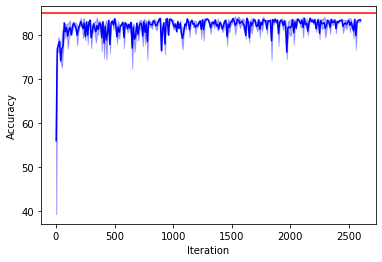

In [59]:
fontsize = 5
f1 = plt.figure()
ax = f1.gca()
plt.plot(np.asarray(iterlist), np.asarray(mean_accuracy),color='blue')
ax.fill_between(np.asarray(iterlist), (np.asarray(mean_accuracy)-std_accuracy), (np.asarray(mean_accuracy)+std_accuracy), color='b', alpha=.3)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
ax.axhline(85,color='red')
plt.show()